# Adelaide Crash Severity — student pipeline (3 models, no grid)

*short comments; clean EDA; 3 models; pick best by macro‑F1*

In [26]:

# imports
import os, re, warnings, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils.class_weight import compute_class_weight

warnings.filterwarnings("ignore")
np.random.seed(42)


In [27]:

CASUALTY_CSV = '2019-2023_DATA_SA_Casualty.csv'
CRASH_CSV    = '2019-2023_DATA_SA_Crash.csv'
UNITS_CSV    = '2019-2023_DATA_SA_Units.csv'
for p in [CASUALTY_CSV, CRASH_CSV, UNITS_CSV]:
    print("path:", p, "exists:", Path(p).exists())


path: 2019-2023_DATA_SA_Casualty.csv exists: True
path: 2019-2023_DATA_SA_Crash.csv exists: True
path: 2019-2023_DATA_SA_Units.csv exists: True


In [28]:

# helpers cleaning + small utils
def clean_cols(df):
    # tidy names
    df = df.rename(columns=lambda c: re.sub(r'\W+','_',str(c).strip().lower()))
    return df.rename(columns=lambda c: re.sub(r'_+','_',c).strip('_'))

def read_clean(path):
    # load + clean
    return clean_cols(pd.read_csv(path, low_memory=False))

def try_col(df, names):
    # first match
    for n in names:
        if n in df.columns:
            return n
    return None

def injury_to_sev(x):
    # map to 4 levels
    if pd.isna(x): return None
    t = str(x).lower()
    if 'fatal' in t or 'death' in t: return 'Fatal'
    if 'serious' in t or 'severe' in t or 'hospital' in t: return 'Serious'
    if 'minor' in t or 'slight' in t: return 'Minor'
    if 'no injury' in t or 'non-injury' in t or 'property' in t or 'not injured' in t: return 'NoInjury'
    if 'injur' in t: return 'Minor'
    return None


In [29]:

#  feature engineering
def agg_units(u):
    # unit features per crash
    if 'report_id' not in u.columns: return None
    unit_type = try_col(u, ['unit_type','unittype','veh_type','vehicle_type','vehicle_class'])
    year_col  = try_col(u, ['vehicle_year','veh_year','year'])
    g = u.groupby('report_id')
    out = g.size().to_frame('unit_count')
    def is_moto(s): s=str(s).lower(); return ('motorcycle' in s) or ('motorbike' in s) or ('motor bike' in s)
    def is_heavy(s): s=str(s).lower(); return ('truck' in s) or ('bus' in s) or ('heavy' in s) or ('lorry' in s)
    if unit_type:
        out['has_motorcycle']  = g[unit_type].apply(lambda s: s.map(is_moto).any()).astype(int)
        out['has_heavy_vehicle'] = g[unit_type].apply(lambda s: s.map(is_heavy).any()).astype(int)
    else:
        out['has_motorcycle'] = 0; out['has_heavy_vehicle'] = 0
    if year_col and pd.api.types.is_numeric_dtype(u[year_col]):
        out['avg_vehicle_year'] = g[year_col].mean()
    else:
        out['avg_vehicle_year'] = np.nan
    return out.reset_index()




In [30]:
def add_time_feats(df):
    # hour/day/month
    dt_col = try_col(df, ['crash_datetime','datetime','crash_date_time','accident_datetime'])
    date_col = try_col(df, ['crash_date','date','accident_date','report_date'])
    time_col = try_col(df, ['crash_time','time_of_crash','acc_time','time','crash_time_hhmm'])
    if dt_col:
        dt = pd.to_datetime(df[dt_col], errors='coerce', dayfirst=True)
        df['crash_hour']    = dt.dt.hour
        df['crash_weekday'] = dt.dt.weekday
        df['crash_month']   = dt.dt.month
        return df
    d = pd.to_datetime(df[date_col], errors='coerce', dayfirst=True) if date_col else None
    if time_col:
        if df[time_col].astype(str).str.contains(':').any():
            t = pd.to_datetime(df[time_col], errors='coerce', format='%H:%M')
            df['crash_hour'] = t.dt.hour
        else:
            def hhmm_to_hour(x):
                s = re.sub(r'\D','', str(x))
                return int(s[:2]) if len(s)>=2 and s[:2].isdigit() else np.nan
            df['crash_hour'] = df[time_col].apply(hhmm_to_hour)
    else:
        df['crash_hour'] = np.nan
    if d is not None:
        df['crash_weekday'] = d.dt.weekday
        df['crash_month']   = d.dt.month
    else:
        df['crash_weekday'] = np.nan
        df['crash_month']   = np.nan
    return df

In [31]:

# helpers plots
def plot_counts(s, title, top=20):
    vc = s.value_counts().head(top)
    fig = plt.figure(figsize=(8,5))
    plt.bar(range(len(vc)), vc.values)
    plt.xticks(range(len(vc)), vc.index.astype(str), rotation=45, ha='right')
    plt.title(title); plt.tight_layout(); plt.show()




In [32]:
def plot_hist(x, title, bins=20):
    s = pd.to_numeric(x, errors='coerce').dropna()
    fig = plt.figure(figsize=(7,4))
    plt.hist(s, bins=bins)
    plt.title(title); plt.tight_layout(); plt.show()


In [33]:

def bar_relation(df, cat_col, target='severity', top=8):
    # severity rates per category
    if cat_col not in df.columns or target not in df.columns: return
    top_vals = df[cat_col].value_counts().head(top).index
    sub = df[df[cat_col].isin(top_vals)]
    ct = pd.crosstab(sub[cat_col], sub[target])
    ct = ct.div(ct.sum(axis=1), axis=0)
    xs = np.arange(len(ct)); labels = list(ct.columns)
    width = 0.8 / max(1, len(labels))
    fig = plt.figure(figsize=(9,5))
    for i, lab in enumerate(labels):
        plt.bar(xs + i*width, ct[lab].values, width=width, label=str(lab))
    plt.xticks(xs + width*len(labels)/2, ct.index.astype(str), rotation=45, ha='right')
    plt.title(f'{cat_col} vs {target} (rates)'); plt.legend(); plt.tight_layout(); plt.show()


In [34]:

def box_by_severity(df, num_col, target='severity'):
    # boxplot num vs severity
    if num_col not in df.columns or target not in df.columns: return
    order = df[target].dropna().unique().tolist()
    data = [df.loc[df[target]==k, num_col].dropna().values for k in order]
    fig = plt.figure(figsize=(7,5))
    plt.boxplot(data, labels=[str(k) for k in order], showfliers=False)
    plt.title(f'{num_col} by {target}'); plt.tight_layout(); plt.show()


In [35]:

def hour_density_by_severity(df, hour_col='crash_hour', target='severity'):
    # overlayed hour density by severity
    if hour_col not in df.columns or target not in df.columns: return
    fig = plt.figure(figsize=(8,5))
    for k, grp in df.dropna(subset=[hour_col]).groupby(target):
        counts, bins = np.histogram(grp[hour_col], bins=np.arange(-0.5,24.5,1), density=True)
        centers = (bins[:-1] + bins[1:]) / 2.0
        plt.plot(centers, counts, label=str(k))
    plt.title(f'{hour_col} by {target}'); plt.xlabel('hour'); plt.ylabel('density')
    plt.legend(); plt.tight_layout(); plt.show()



In [36]:
def corr_heatmap(df, num_cols):
    # numeric corr heatmap
    nums = df[num_cols].select_dtypes(include=[np.number]).dropna(axis=1, how='all')
    if nums.empty:
        print('no numeric columns for heatmap'); return
    corr = nums.corr()
    fig = plt.figure(figsize=(6,5))
    plt.imshow(corr.values, aspect='auto')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title('numeric correlation'); plt.tight_layout(); plt.show()



In [37]:
def plot_cm(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig = plt.figure(figsize=(6,5))
    plt.imshow(cm, aspect='auto')
    plt.title(title); plt.xlabel('pred'); plt.ylabel('true')
    plt.xticks(range(len(labels)), labels, rotation=45); plt.yticks(range(len(labels)), labels)
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center')
    plt.tight_layout(); plt.show()

## 1) load data + quick look

In [38]:

# load
casualty = read_clean(CASUALTY_CSV)
crash    = read_clean(CRASH_CSV)
units    = read_clean(UNITS_CSV)

# head/describe/missing
print('shapes:', casualty.shape, crash.shape, units.shape)
display(casualty.head(5)); display(crash.head(5)); display(units.head(5))
display(casualty.select_dtypes(include=[np.number]).describe().T)
display(crash.select_dtypes(include=[np.number]).describe().T)
display(units.select_dtypes(include=[np.number]).describe().T)
display((casualty.isna().mean()*100).sort_values(ascending=False).head(30).to_frame('missing_%'))
display((crash.isna().mean()*100).sort_values(ascending=False).head(30).to_frame('missing_%'))
display((units.isna().mean()*100).sort_values(ascending=False).head(30).to_frame('missing_%'))


shapes: (25185, 12) (63069, 34) (134724, 18)


,report_id,und_unit_number,casualty_number,casualty_type,sex,age,position_in_veh,thrown_out,injury_extent,seat_belt,helmet,hospital
0,2019-3-13/09/2024,2,1,Pedestrian,Male,041,NaN,NaN,Treated at Hospital,NaN,NaN,XXXXXX
1,2019-4-13/09/2024,1,1,Rider,Male,021,Rider of Motorcycle,Thrown Out,Admitted to Hospital,NaN,Worn,LYELL MCEWIN
2,2019-6-13/09/2024,1,1,Driver,Female,026,Driver,Not Thrown Out,Treated at Hospital,Fitted - Worn,NaN,XXXXXX
3,2019-7-13/09/2024,1,1,Passenger,Male,002,Rear Seat Right Passenger,Not Thrown Out,Treated at Hospital,Child Restraint - Worn,NaN,FLINDERS MED CENTRE
4,2019-7-13/09/2024,1,2,Passenger,Male,XXX,Rear Seat Left Passenger,Not Thrown Out,Treated at Hospital,Child Restraint - Worn,NaN,FLINDERS MED CENTRE


,report_id,stats_area,suburb,postcode,lga_name,total_units,total_cas,total_fats,total_si,total_mi,...,unit_resp,entity_code,csef_severity,traffic_ctrls,dui_involved,drugs_involved,accloc_x,accloc_y,unique_loc,crash_date_time
0,2019-1-13/09/2024,2 Metropolitan,HAMPSTEAD GARDENS,5086,CITY OF PORT ADELAIDE ENFIELD,2,0,0,0,0,...,1,Driver Rider,1: PDO,Give Way Sign,NaN,NaN,1331810.03,1676603.26,1.331810e+13,12/6/2019 11:15:00
1,2019-2-13/09/2024,2 Metropolitan,DRY CREEK,5094,CITY OF SALISBURY,2,0,0,0,0,...,2,Driver Rider,1: PDO,No Control,NaN,NaN,1328376.20,1682942.63,1.328376e+13,1/1/2019 0:49:00
2,2019-3-13/09/2024,2 Metropolitan,MILE END,5031,CITY OF WEST TORRENS,2,1,0,0,1,...,1,Driver Rider,2: MI,No Control,NaN,NaN,1325819.68,1670994.26,1.325820e+13,1/1/2019 0:00:00
3,2019-4-13/09/2024,2 Metropolitan,PARALOWIE,5108,CITY OF SALISBURY,2,1,0,1,0,...,1,Driver Rider,3: SI,No Control,NaN,NaN,1328320.60,1690237.08,1.328321e+13,1/1/2019 0:05:00
4,2019-5-13/09/2024,2 Metropolitan,MOUNT BARKER,5251,DC MT.BARKER.,2,0,0,0,0,...,2,Animal,1: PDO,No Control,NaN,NaN,1353279.99,1655645.15,1.353280e+13,1/1/2019 5:15:00


,report_id,unit_no,no_of_cas,veh_reg_state,unit_type,veh_year,direction_of_travel,sex,age,lic_state,licence_class,licence_type,towing,unit_movement,number_occupants,postcode,rollover,fire
0,2019-1-13/09/2024,1,0,SA,Station Wagon,1998,South,Female,085,SA,C,Full,Not Towing,Right Turn,1.0,XXXX,NaN,NaN
1,2019-1-13/09/2024,2,0,SA,Motor Cars - Sedan,2009,East,Female,022,SA,C,Provisional 2,Not Towing,Straight Ahead,1.0,5085,NaN,NaN
2,2019-2-13/09/2024,1,0,SA,Motor Cars - Sedan,2007,North East,Male,021,SA,C,Provisional 2,Not Towing,Straight Ahead,4.0,5114,NaN,NaN
3,2019-2-13/09/2024,2,0,SA,Motor Cars - Sedan,2002,North East,Female,031,SA,C,Full,Not Towing,Straight Ahead,1.0,5108,NaN,NaN
4,2019-3-13/09/2024,1,0,UNKNOWN,Motor Vehicle - Type Unknown,XXXX,East,Unknown,XXX,UNKNOWN,XX,Unknown,Unknown,Straight Ahead,1.0,XXXX,NaN,NaN


,count,mean,std,min,25%,50%,75%,max
und_unit_number,25185.0,1.415207,0.583116,1.0,1.0,1.0,2.0,7.0
casualty_number,25185.0,1.152948,0.491544,1.0,1.0,1.0,1.0,11.0


,count,mean,std,min,25%,50%,75%,max
postcode,63069.0,5.126707e+03,1.786098e+02,8.720000e+02,5.042000e+03,5.087000e+03,5.158000e+03,5.960000e+03
total_units,63069.0,2.136137e+00,5.643858e-01,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.500000e+01
total_cas,63069.0,3.993245e-01,6.799460e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.100000e+01
total_fats,63069.0,7.832691e-03,9.356564e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
total_si,63069.0,6.106011e-02,2.733327e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00
total_mi,63069.0,3.304317e-01,6.219720e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.100000e+01
year,63069.0,2.021016e+03,1.424587e+00,2.019000e+03,2.020000e+03,2.021000e+03,2.022000e+03,2.023000e+03
area_speed,63069.0,6.417376e+01,1.695517e+01,5.000000e+00,5.000000e+01,6.000000e+01,6.000000e+01,1.100000e+02
unit_resp,63069.0,1.463175e+00,7.685645e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,9.000000e+00
accloc_x,63059.0,1.330392e+06,5.803458e+04,4.157482e+05,1.324123e+06,1.329024e+06,1.334935e+06,1.583160e+06


,count,mean,std,min,25%,50%,75%,max
unit_no,134724.0,1.642625,0.722131,1.0,1.0,2.0,2.0,15.0
no_of_cas,134724.0,0.186938,0.457359,0.0,0.0,0.0,0.0,11.0
number_occupants,117636.0,1.339896,1.700376,0.0,1.0,1.0,1.0,115.0


,missing_%
helmet,81.957514
seat_belt,23.089140
hospital,22.291046
position_in_veh,13.373040
thrown_out,5.284892
casualty_number,0.000000
und_unit_number,0.000000
report_id,0.000000
casualty_type,0.000000
age,0.000000


,missing_%
drugs_involved,97.688246
dui_involved,96.659215
lga_name,0.729360
accloc_x,0.015856
accloc_y,0.015856
unique_loc,0.014270
other_feat,0.001586
report_id,0.000000
stats_area,0.000000
suburb,0.000000


,missing_%
fire,99.922805
rollover,97.163831
lic_state,19.571123
licence_type,19.539206
licence_class,19.538464
towing,16.075087
veh_year,15.462724
veh_reg_state,15.461982
postcode,15.225943
sex,15.211841


## 2) derive crash-level severity label

In [39]:

# severity from casualty if needed
have_counts = all([(c in crash.columns) for c in ['fatalities','serious_injuries','minor_injuries']])
if (not have_counts) and ('report_id' in casualty.columns):
    inj_col = try_col(casualty, ['injury_extent','injury_severity','injury_type','injury_level','hospitalisation'])
    if inj_col:
        tmp = casualty[['report_id', inj_col]].copy()
        tmp['sev_bucket'] = tmp[inj_col].map(injury_to_sev)
        order = {'NoInjury':0,'Minor':1,'Serious':2,'Fatal':3}
        tmp['sev_rank'] = tmp['sev_bucket'].map(order).fillna(0).astype(int)
        agg = tmp.groupby('report_id').agg(
            fatalities=('sev_bucket', lambda s:(s=='Fatal').sum()),
            serious_injuries=('sev_bucket', lambda s:(s=='Serious').sum()),
            minor_injuries=('sev_bucket', lambda s:(s=='Minor').sum()),
            total_casualties=('sev_bucket','count'),
            max_sev_rank=('sev_rank','max')
        ).reset_index()
        inv = {v:k for k,v in order.items()}
        agg['derived_severity'] = agg['max_sev_rank'].map(inv)
        crash = crash.merge(agg.drop(columns=['max_sev_rank']), on='report_id', how='left')

def final_sev(r):
    # final label
    if pd.notna(r.get('derived_severity', np.nan)): return r['derived_severity']
    fat, ser, mnr = r.get('fatalities',0) or 0, r.get('serious_injuries',0) or 0, r.get('minor_injuries',0) or 0
    if fat>0: return 'Fatal'
    if ser>0: return 'Serious'
    if mnr>0: return 'Minor'
    return 'NoInjury'

crash['severity'] = crash.apply(final_sev, axis=1)
print(crash['severity'].value_counts())


severity
NoInjury    47028
Serious     15575
Fatal         466
Name: count, dtype: int64


## 3) add unit + time features

In [40]:

# units
ua = agg_units(units) if 'report_id' in units.columns else None
if ua is not None:
    crash = crash.merge(ua, on='report_id', how='left')

# time
crash = add_time_feats(crash)

display(crash.head(5))


,report_id,stats_area,suburb,postcode,lga_name,total_units,total_cas,total_fats,total_si,total_mi,...,total_casualties,derived_severity,severity,unit_count,has_motorcycle,has_heavy_vehicle,avg_vehicle_year,crash_hour,crash_weekday,crash_month
0,2019-1-13/09/2024,2 Metropolitan,HAMPSTEAD GARDENS,5086,CITY OF PORT ADELAIDE ENFIELD,2,0,0,0,0,...,NaN,NaN,NoInjury,2,0,0,NaN,11,2,6
1,2019-2-13/09/2024,2 Metropolitan,DRY CREEK,5094,CITY OF SALISBURY,2,0,0,0,0,...,NaN,NaN,NoInjury,2,0,0,NaN,0,1,1
2,2019-3-13/09/2024,2 Metropolitan,MILE END,5031,CITY OF WEST TORRENS,2,1,0,0,1,...,1.0,Serious,Serious,2,0,0,NaN,0,1,1
3,2019-4-13/09/2024,2 Metropolitan,PARALOWIE,5108,CITY OF SALISBURY,2,1,0,1,0,...,1.0,Serious,Serious,2,0,0,NaN,0,1,1
4,2019-5-13/09/2024,2 Metropolitan,MOUNT BARKER,5251,DC MT.BARKER.,2,0,0,0,0,...,NaN,NaN,NoInjury,2,0,0,NaN,5,1,1


## 4) EDA — single variable charts

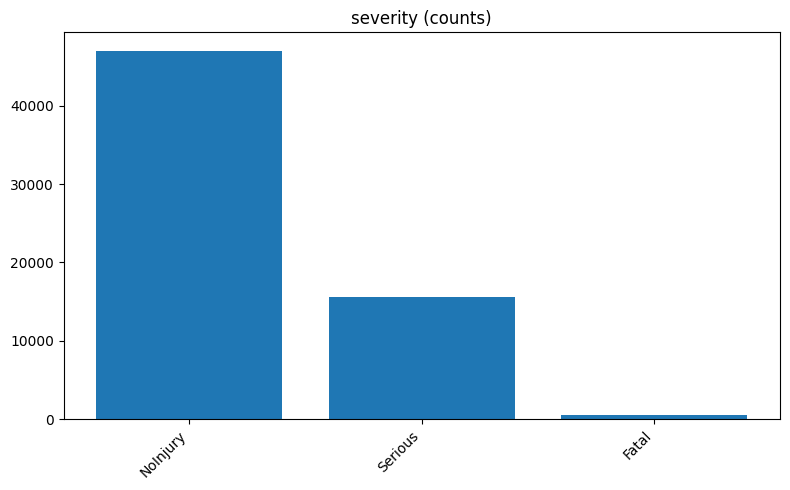

In [41]:

# severity
if 'severity' in crash.columns:
    plot_counts(crash['severity'], 'severity (counts)')


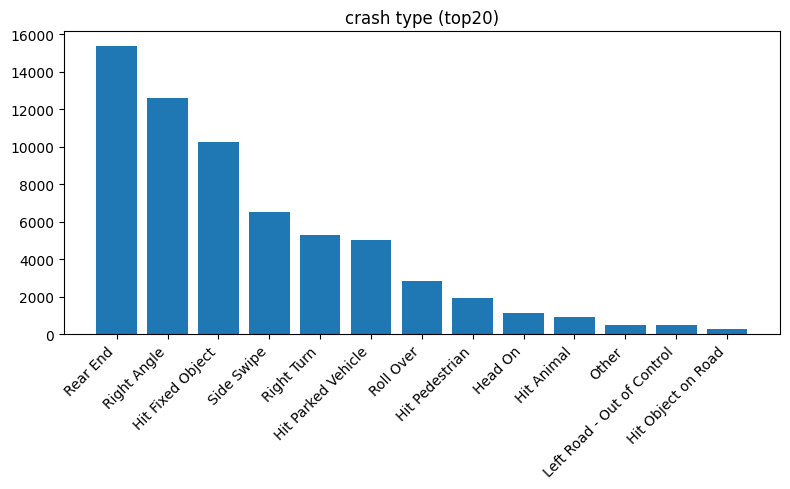

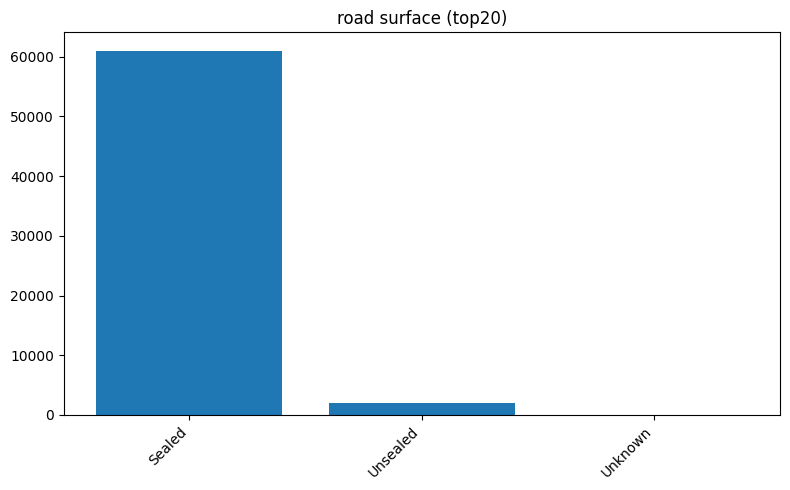

In [42]:

# top categories
for col, title in [
    ('crash_type','crash type (top20)'), ('road_surface','road surface (top20)'),
    ('day_night','day/night'), ('light_condition','light condition'),
    ('weather_condition','weather'), ('traffic_controls','traffic controls')
]:
    if col in crash.columns: plot_counts(crash[col], title, top=20)


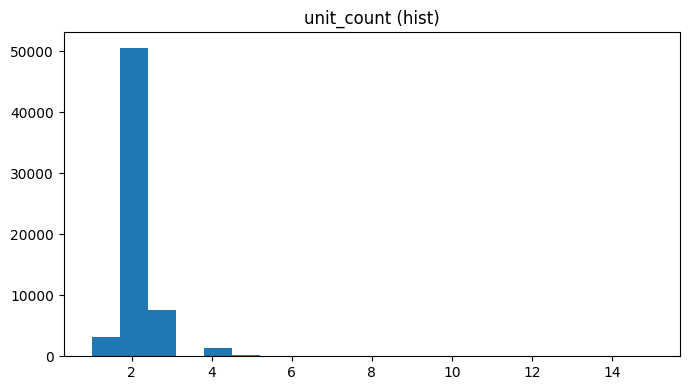

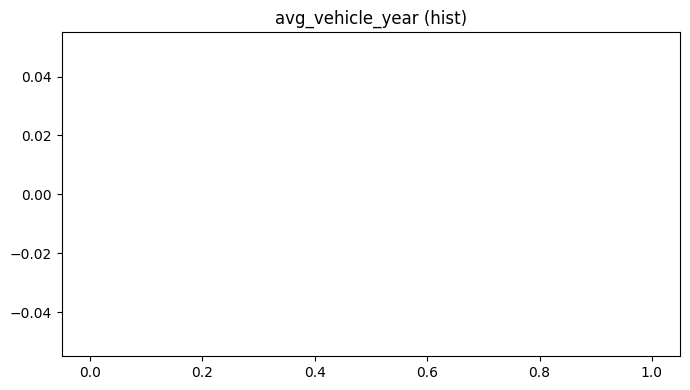

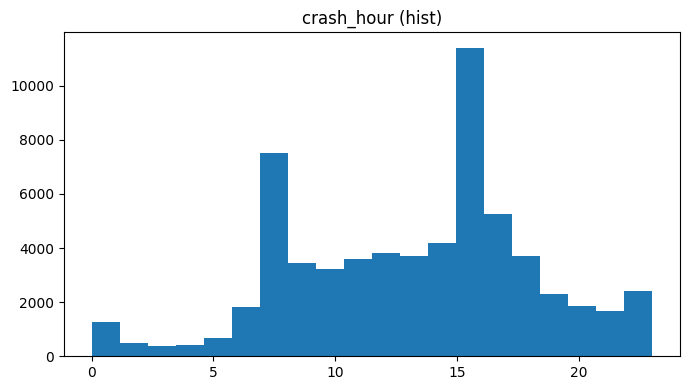

In [43]:

# numeric hists
for col in ['speed_zone','unit_count','avg_vehicle_year','crash_hour']:
    if col in crash.columns: plot_hist(crash[col], f'{col} (hist)')


## 5) EDA — relationships

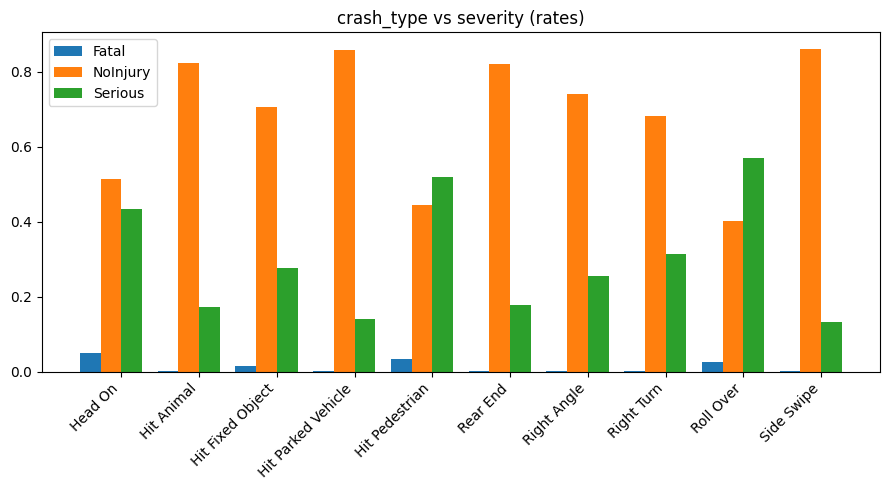

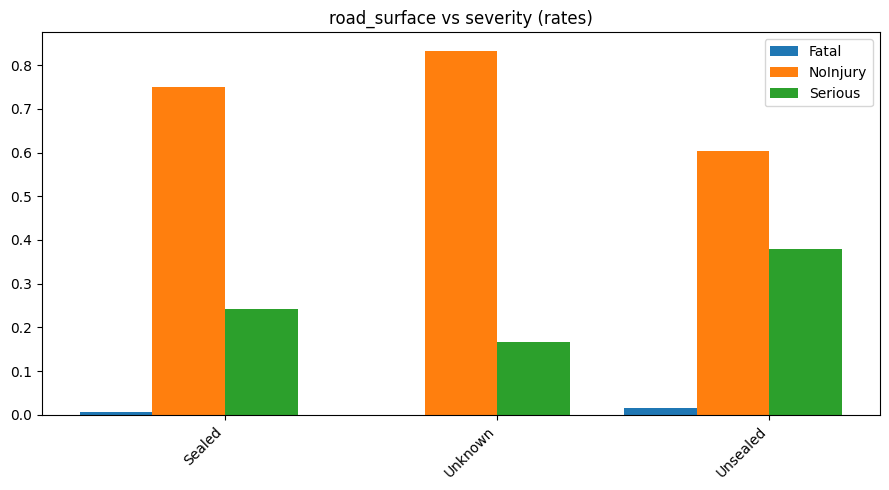

In [44]:

# category vs severity rates
for col in ['crash_type','road_surface','day_night','light_condition','weather_condition','traffic_controls']:
    if col in crash.columns: bar_relation(crash, col, target='severity', top=10)




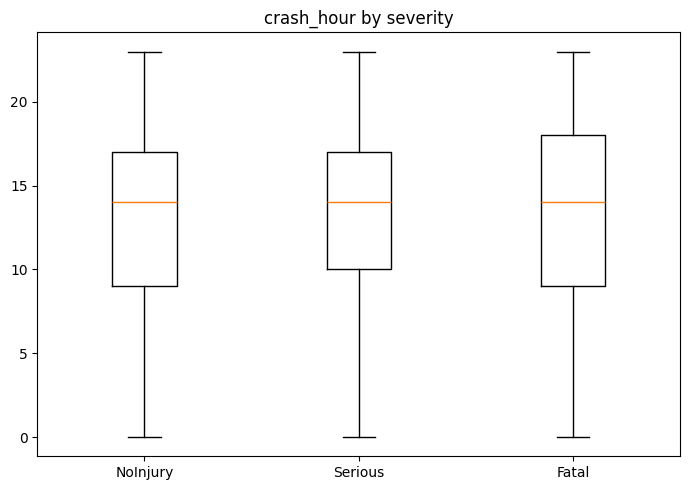

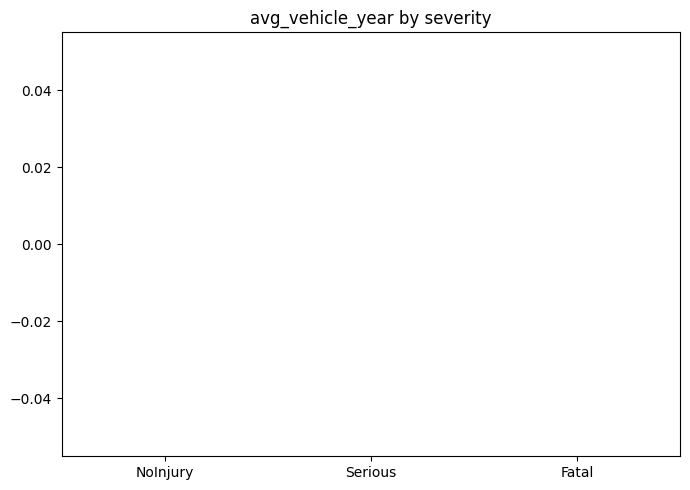

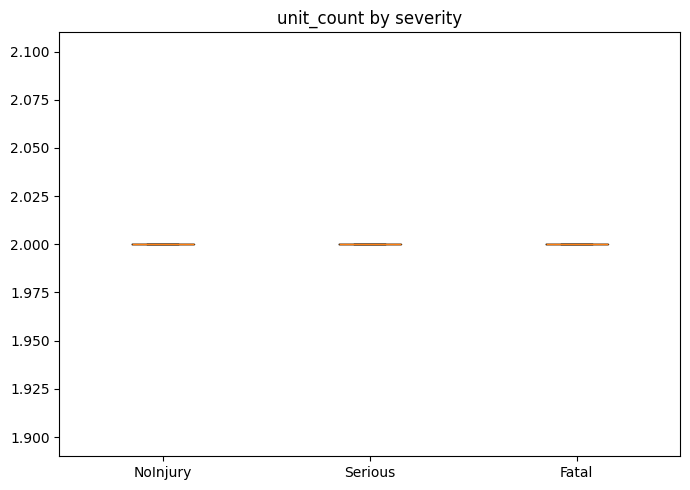

In [45]:
# numeric vs severity (boxplots)
for col in ['speed_zone','crash_hour','avg_vehicle_year','unit_count']:
    if col in crash.columns: box_by_severity(crash, col, target='severity')


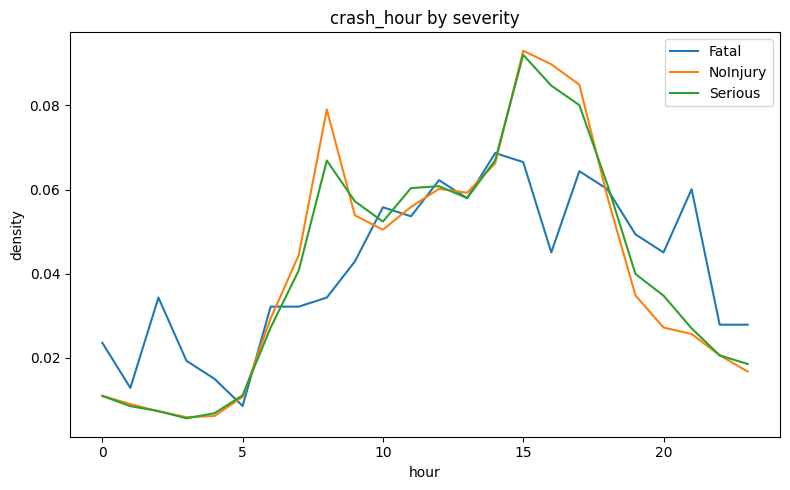

In [46]:

# hour lines by severity
hour_density_by_severity(crash, hour_col='crash_hour', target='severity')



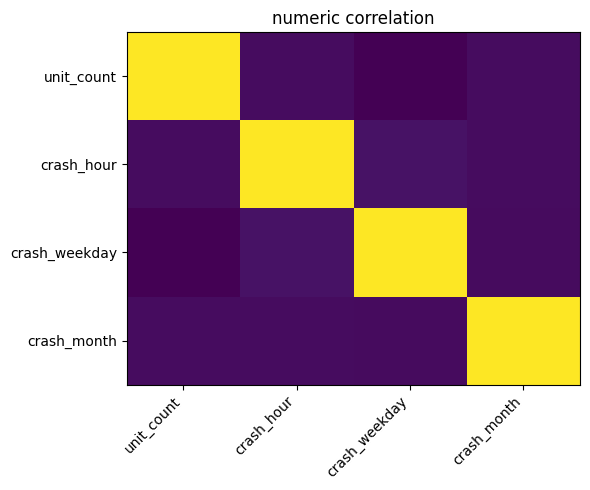

In [47]:
# numeric correlation
num_cols_all = ['speed_zone','unit_count','avg_vehicle_year','crash_hour','crash_weekday','crash_month']
num_cols_present = [c for c in num_cols_all if c in crash.columns]
corr_heatmap(crash, num_cols_present)

## 6) build modeling dataset

In [48]:

# pick features
possible = [
    'crash_type','road_surface','weather_condition','day_night','light_condition',
    'speed_zone','traffic_controls','horizontal_alignment','vertical_alignment','position_type',
    'unit_count','has_motorcycle','has_heavy_vehicle','avg_vehicle_year',
    'crash_hour','crash_weekday','crash_month'
]
feat = [c for c in possible if c in crash.columns]
data = crash[crash['severity'].notna()].copy()
X = data[feat].copy()
y = data['severity'].copy()
print('X shape:', X.shape, '| y:', y.shape)


X shape: (63069, 10) | y: (63069,)


## 7) split + preprocess

In [49]:

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# simple imputers + onehot
cat_cols = [c for c in X.columns if X[c].dtype=='object']
num_cols = [c for c in X.columns if c not in cat_cols]
prep = ColumnTransformer([
    ('num', SimpleImputer(strategy='median'), num_cols),
    ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                      ('oh', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
])
print('features:', len(feat), '| cats:', len(cat_cols), '| nums:', len(num_cols))


features: 10 | cats: 3 | nums: 7


## 8) handle class imbalance (for GB via sample_weight)

In [50]:

classes_ = np.unique(y_train)
cw = compute_class_weight(class_weight='balanced', classes=classes_, y=y_train)
cw_map = {cls:w for cls, w in zip(classes_, cw)}
sample_w = y_train.map(cw_map).values
print('class weights:', cw_map)


class weights: {'Fatal': np.float64(45.0893655049151), 'NoInjury': np.float64(0.4470345365300445), 'Serious': np.float64(1.3497859818084537)}


## 9) define models (fixed params)

In [51]:

dt = Pipeline([
    ('prep', prep),
    ('clf', DecisionTreeClassifier(max_depth=16, min_samples_leaf=5, class_weight='balanced', random_state=42))
])

rf = Pipeline([
    ('prep', prep),
    ('clf', RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_leaf=2,
                                   max_features='sqrt', class_weight='balanced',
                                   random_state=42, n_jobs=-1))
])

gb = Pipeline([
    ('prep', prep),
    ('clf', GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=3, random_state=42))
])


## 10) train models

In [52]:

dt.fit(X_train, y_train)
rf.fit(X_train, y_train)
# pass weights to final step in pipeline
gb.fit(X_train, y_train, clf__sample_weight=sample_w)
print('trained dt, rf, gb')


trained dt, rf, gb


## 11) evaluation helper

In [53]:

def evaluate(model, name, X_test=X_test, y_test=y_test):
    # predict
    y_pred = model.predict(X_test)
    acc  = accuracy_score(y_test, y_pred)
    f1m  = f1_score(y_test, y_pred, average='macro')
    print(f"\n=== {name} ===")
    print("accuracy:", round(acc,4), "| macro-F1:", round(f1m,4))
    print(classification_report(y_test, y_pred, digits=3))
    labs = sorted(y_test.unique())
    plot_cm(y_test, y_pred, labs, f'{name} — confusion')
    # roc (macro ovr)
    try:
        proba = model.predict_proba(X_test)
        lb = LabelBinarizer(); yb = lb.fit_transform(y_test)
        if yb.ndim==1 or yb.shape[1]==1:
            auc_val = roc_auc_score(yb, proba[:,1]); print('roc-auc (binary):', round(auc_val,4))
            fpr, tpr, _ = roc_curve(yb, proba[:,1])
            fig = plt.figure(figsize=(6,5))
            plt.plot(fpr, tpr, label=f'auc={round(auc_val,4)}')
            plt.plot([0,1],[0,1],'--')
            plt.title(f'roc — {name} (binary)'); plt.xlabel('fpr'); plt.ylabel('tpr')
            plt.legend(); plt.tight_layout(); plt.show()
        else:
            auc_val = roc_auc_score(yb, proba, multi_class='ovr', average='macro')
            print('roc-auc (macro ovr):', round(auc_val,4))
    except Exception as e:
        print('no roc:', e)
    return {'name': name, 'acc': acc, 'f1': f1m}


## 12) evaluate all models


=== DecisionTree ===
accuracy: 0.5422 | macro-F1: 0.3674
              precision    recall  f1-score   support

       Fatal      0.031     0.312     0.056        93
    NoInjury      0.818     0.548     0.657      9406
     Serious      0.308     0.530     0.390      3115

    accuracy                          0.542     12614
   macro avg      0.386     0.464     0.367     12614
weighted avg      0.686     0.542     0.586     12614



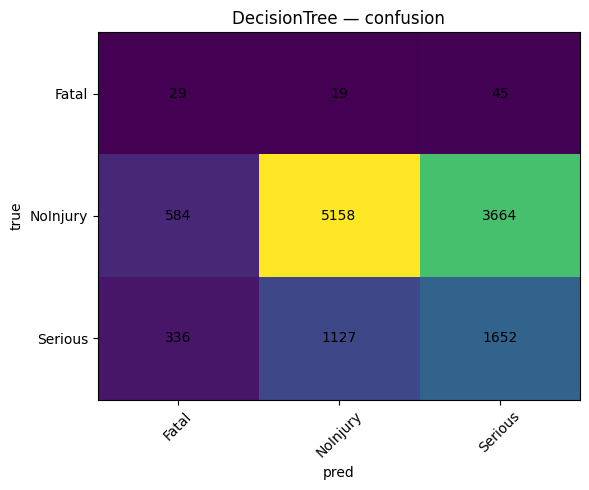

roc-auc (macro ovr): 0.6133

=== RandomForest ===
accuracy: 0.6661 | macro-F1: 0.4078
              precision    recall  f1-score   support

       Fatal      0.062     0.097     0.076        93
    NoInjury      0.792     0.765     0.778      9406
     Serious      0.354     0.386     0.369      3115

    accuracy                          0.666     12614
   macro avg      0.403     0.416     0.408     12614
weighted avg      0.679     0.666     0.672     12614



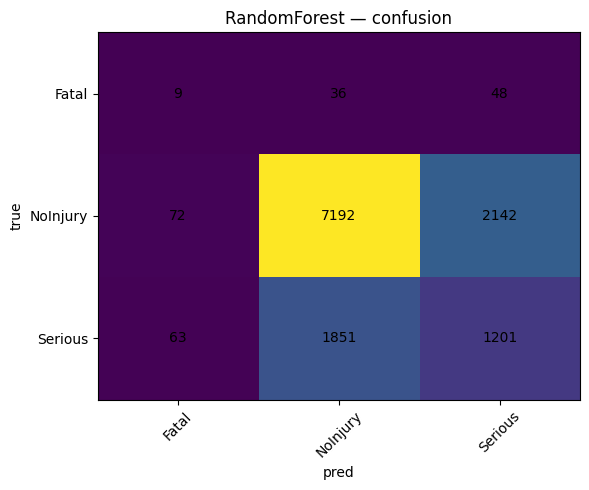

roc-auc (macro ovr): 0.6916

=== GradientBoosting ===
accuracy: 0.538 | macro-F1: 0.3622
              precision    recall  f1-score   support

       Fatal      0.027     0.656     0.051        93
    NoInjury      0.830     0.592     0.691      9406
     Serious      0.320     0.373     0.345      3115

    accuracy                          0.538     12614
   macro avg      0.392     0.540     0.362     12614
weighted avg      0.698     0.538     0.601     12614



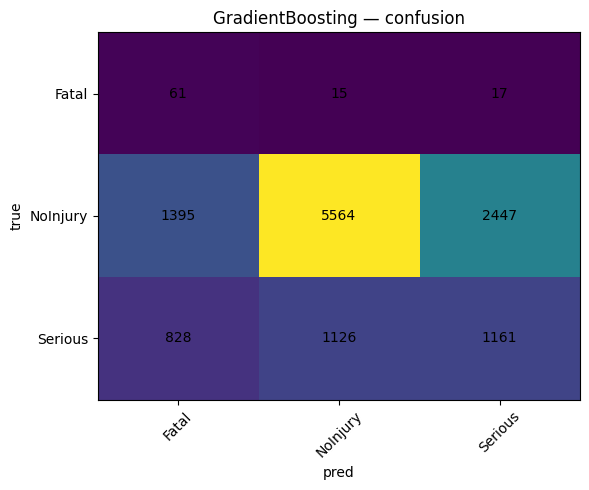

roc-auc (macro ovr): 0.6939
scores: [{'name': 'DecisionTree', 'acc': 0.5421753607103219, 'f1': 0.36737350491227794}, {'name': 'RandomForest', 'acc': 0.6660853020453464, 'f1': 0.40776382407422096}, {'name': 'GradientBoosting', 'acc': 0.5379736800380529, 'f1': 0.36218126578972276}]


In [54]:

m_dt = evaluate(dt, 'DecisionTree')
m_rf = evaluate(rf, 'RandomForest')
m_gb = evaluate(gb, 'GradientBoosting')
scores = [m_dt, m_rf, m_gb]
print('scores:', scores)


## 13) pick best + feature importances


BEST MODEL: RandomForest | macro-F1: 0.4078 | acc: 0.6661


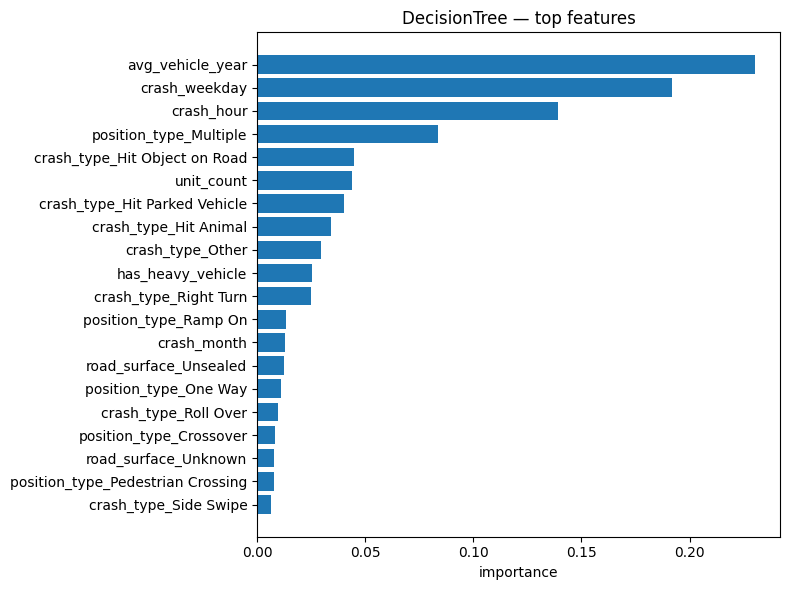

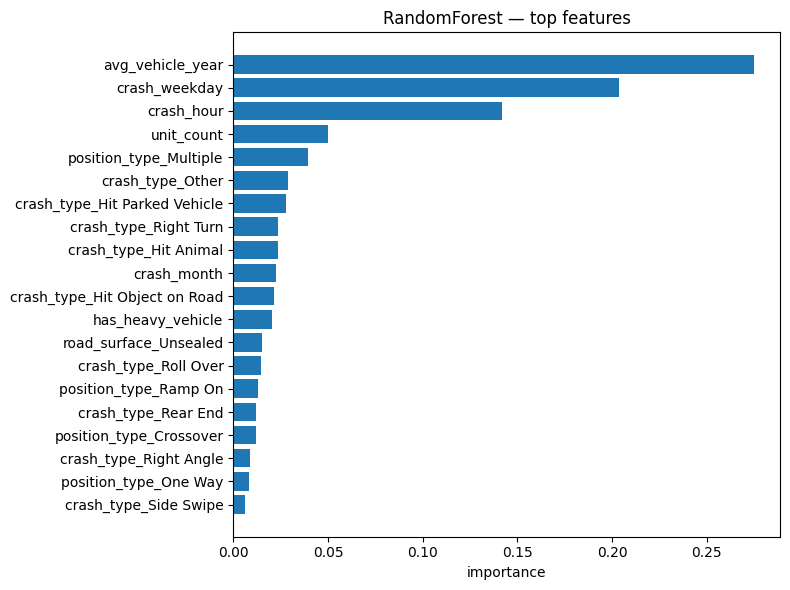

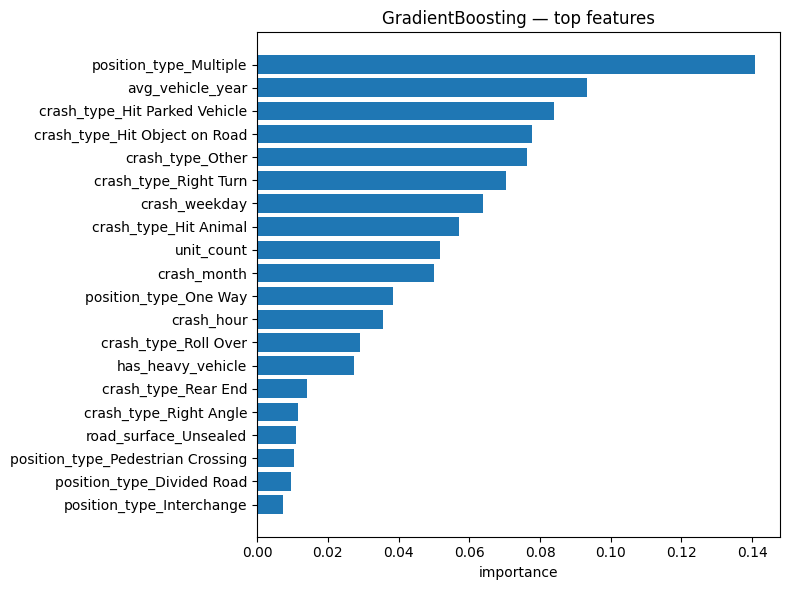

In [55]:

best = max(scores, key=lambda d: d['f1'])
best_name = best['name']
print("\nBEST MODEL:", best_name, "| macro-F1:", round(best['f1'],4), "| acc:", round(best['acc'],4))
best_model = {'DecisionTree': dt, 'RandomForest': rf, 'GradientBoosting': gb}[best_name]

def get_feat_names(prep, Xcols):
    names=[]
    for name, trans, cols in prep.transformers_:
        if name=='num' and cols is not None: names.extend(cols)
        if name=='cat':
            oh = trans.named_steps.get('oh', None)
            if oh is not None:
                try: names.extend(list(oh.get_feature_names_out(cols)))
                except: names.extend(list(oh.get_feature_names(cols)))
            else:
                if cols is not None: names.extend(cols)
    return names

def plot_importance(model, title, top=20):
    clf = model.named_steps['clf']
    if not hasattr(clf, 'feature_importances_'):
        print(title, '→ no feature_importances_'); return
    names = get_feat_names(model.named_steps['prep'], X.columns)
    imps = clf.feature_importances_
    order = np.argsort(imps)[::-1][:top]
    fig = plt.figure(figsize=(8,6))
    y = np.arange(len(order))
    plt.barh(y, imps[order][::-1])
    plt.yticks(y, [names[i] if i < len(names) else f'feat_{i}' for i in order][::-1])
    plt.title(title); plt.xlabel('importance'); plt.tight_layout(); plt.show()

# try importances
plot_importance(dt, 'DecisionTree — top features', top=20)
plot_importance(rf, 'RandomForest — top features', top=20)
plot_importance(gb, 'GradientBoosting — top features', top=20)
